# Face Recognition using Siamese Networks

In [16]:
from sklearn.datasets import fetch_lfw_pairs
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

## Extract dataset

I am using the scikit-learn LFW datasets to directly get the pairs 👍

In [17]:
lfw_pairs_train = fetch_lfw_pairs(subset="train", resize=0.4)
lfw_pairs_test = fetch_lfw_pairs(subset="test", resize=0.4)
classes = list(lfw_pairs_train.target_names)

X = lfw_pairs_train.pairs
X = X.astype("float32")
y = lfw_pairs_train.target.astype("float32")

X_test = lfw_pairs_test.pairs
X_test = X_test.astype("float32")
y_test = lfw_pairs_test.target.astype("float32")

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

IMG_SHAPE = (X_train.shape[2], X_train.shape[3], 1) # channel=1 because grayscale image
X_train.shape

(1474, 2, 50, 37)

In [18]:
def visualize(image0, image1, label, proba=None):
    # Plot the images
    plt.imshow(np.concatenate([image0, image1], axis=1), cmap='gray')
    plt.title("Label: {}".format(label))
    if proba is not None:
        plt.suptitle("Proba: {:.2f}".format(proba))
    plt.show()

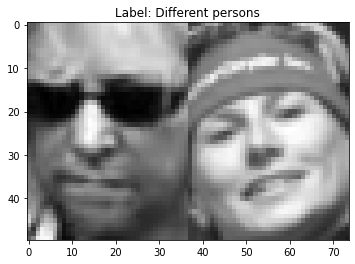

In [19]:
visualize(X_train[0][0], X_train[0][1], classes[int(y_train[0])])

## Data Augmentation

I add 500 new pairs of images by zooming and flipped horizontally (randomly chosen images).

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

##### Data Augmentation

nb_new_data = 500

# Flip horizontally images
augmented_X_train_1 = X_train[:nb_new_data, 0]
augmented_X_train_2 = X_train[:nb_new_data, 1]
augmented_y_train = y_train[:nb_new_data]

datagen = ImageDataGenerator(
    zoom_range=[0.9,0.9],
    horizontal_flip=True,
)
datagen.fit(augmented_X_train_1.reshape(augmented_X_train_1.shape[0], IMG_SHAPE[0], IMG_SHAPE[1], 1))
datagen.fit(augmented_X_train_2.reshape(augmented_X_train_2.shape[0], IMG_SHAPE[0], IMG_SHAPE[1], 1))

data_generator_1 = datagen.flow(augmented_X_train_1.reshape(augmented_X_train_1.shape[0], IMG_SHAPE[0], IMG_SHAPE[1], 1), shuffle=False, batch_size=1)
data_generator_2 = datagen.flow(augmented_X_train_2.reshape(augmented_X_train_2.shape[0], IMG_SHAPE[0], IMG_SHAPE[1], 1), shuffle=False, batch_size=1)

X_train_aug_1 = [data_generator_1.next() for i in range(0, nb_new_data)]
X_train_aug_2 = [data_generator_2.next() for i in range(0, nb_new_data)]

augmented_X_train_1 = np.asarray(X_train_aug_1).reshape(nb_new_data, IMG_SHAPE[0], IMG_SHAPE[1])
augmented_X_train_2 = np.asarray(X_train_aug_2).reshape(nb_new_data, IMG_SHAPE[0], IMG_SHAPE[1])

augmented_X_train = np.array([augmented_X_train_1, augmented_X_train_2])
arr = np.transpose(augmented_X_train, (1, 0, 2, 3))

# reshape to the desired shape
augmented_X_train = arr.reshape(nb_new_data, 2, IMG_SHAPE[0], IMG_SHAPE[1])

# Concatenate the augmented data with the original training data
X_train = np.concatenate([X_train, augmented_X_train])
y_train = np.concatenate([y_train, augmented_y_train])

######

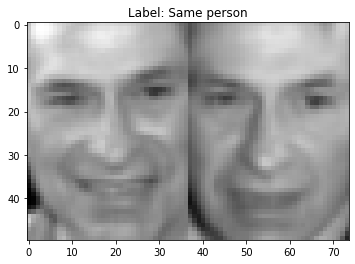

In [21]:
visualize(augmented_X_train[2][0], augmented_X_train[2][1], classes[int(y_train[2])])

## Normalization

Easy for grayscale images.

In [22]:
X_train /= 255
X_val /= 255
X_test /= 255

Also, we divide the different sets into img1 and img2 to help our next work

In [23]:
img1_train = X_train[:, 0]
img2_train = X_train[:, 1]

img1_val = X_val[:, 0]
img2_val = X_val[:, 1]

img1_test = X_test[:, 0]
img2_test = X_test[:, 1]

## Training

Let's now train our model with the chosen parameters

Epoch 1/30
62/62 [==============================] - 10s 145ms/step - loss: 1.4705 - accuracy: 0.5309 - val_loss: 1.4535 - val_accuracy: 0.5413
Epoch 2/30
62/62 [==============================] - 9s 139ms/step - loss: 1.4188 - accuracy: 0.5846 - val_loss: 1.4292 - val_accuracy: 0.5358
Epoch 3/30
62/62 [==============================] - 10s 154ms/step - loss: 1.3859 - accuracy: 0.6079 - val_loss: 1.4036 - val_accuracy: 0.5358
Epoch 4/30
62/62 [==============================] - 9s 150ms/step - loss: 1.3624 - accuracy: 0.6160 - val_loss: 1.3847 - val_accuracy: 0.5565
Epoch 5/30
62/62 [==============================] - 9s 147ms/step - loss: 1.3211 - accuracy: 0.6606 - val_loss: 1.3650 - val_accuracy: 0.6033
Epoch 6/30
62/62 [==============================] - 10s 160ms/step - loss: 1.2881 - accuracy: 0.6834 - val_loss: 1.3487 - val_accuracy: 0.6047
Epoch 7/30
62/62 [==============================] - 8s 123ms/step - loss: 1.2632 - accuracy: 0.6940 - val_loss: 1.3383 - val_accuracy: 0.6143
Epo

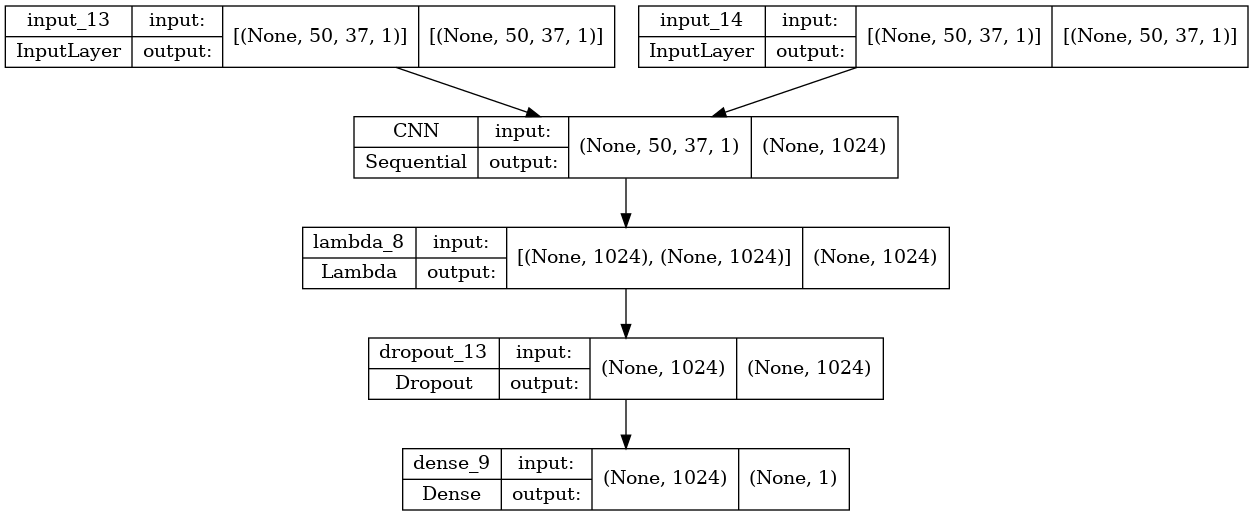

In [25]:
from siamese_network import SiameseNetwork
import tensorflow as tf

batch_size = 32
epochs = 30
lr = 1e-4
activation_fct = "relu"
cnn_filters = [16, 32, 64]
fine_tunning = False
dense_neurons = 1024
dropout_rate = 0.2

sn = SiameseNetwork(IMG_SHAPE, cnn_filters, epochs, lr, batch_size, dense_neurons, activation_fct, fine_tunning, dropout_rate)
model = sn.get_siamese_network()
history = sn.train([img1_train, img2_train], y_train, [img1_val, img2_val], y_val)
tf.keras.utils.plot_model(model, show_shapes=True)

In [26]:
def plot_training(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()

def plot_training_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='lower right')
    plt.show()

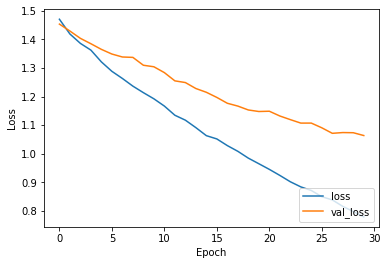

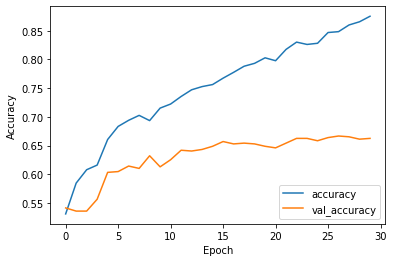

In [27]:
plot_training_loss(history)
plot_training(history)

It seems to be overfitted. To reduce this overfitting, I added Dropout and Data augmentation.

Siamese Networks can be particularly prone to overfitting, as they can easily learn to memorize the training pairs instead of learning to generalize. But, some techniques can help reducing a lot this overfitting:
* triplet loss
* center loss

For the challenge, I tried my best to optimize the architecture without using the anchors and the triplet loss !

In [28]:
test_loss, test_acc = sn.evaluate([img1_test, img2_test], y_test)

32/32 [==============================] - 1s 36ms/step - loss: 1.0662 - accuracy: 0.6460


64% of accuracy is not enough to build a robust application but at least I tried !